### 3D cyl

In [1]:
import os
import time

import sys

benchmark_path = '../BenchmarkData/'
sys.path.append('../')

from ofelia.aux_obj import *

import matplotlib.pyplot as plt
from matplotlib import cm

from constants import *

import numpy as np
import gmsh

# Neutronic transport of a 3D cylindrical $UO_2$ pin 

1. *materials.py*:
    - Materials definition



2. *build_xml.py*:
    - Geometry definition
    - Settings definition
    - Plots definition
    - Tallies definition

In [2]:
input_folder =  './build_xml/it0'
os.makedirs(input_folder, exist_ok=True)
os.system(f"rm {input_folder}/*.h5")

from build_xml import *

print('The number of axial divisions is '+ str(n_div))

#configure cross sections
openmc.config["cross_sections"]="/home/paolo/Downloads/xs/jeff-3.3-hdf5/cross_sections.xml"

# RUN OPENMC SIMULATION
print('  Running OpenMC')
openmc.plot_geometry(cwd=input_folder)
openmc.run(threads = 8, cwd=input_folder, output = True)

The number of axial divisions is 8
  Running OpenMC
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%

### Post processing
Evaluate the power axial profile

In [3]:
sp = openmc.StatePoint(input_folder+"/statepoint.1000.h5")

# OpenMC normalization constant
tally_integral = sp.get_tally(name = tallyDict["integral"])
heating_integral = tally_integral.get_slice(scores=['kappa-fission']) 
Qp = float(heating_integral.mean) # measure of the fission energy (eV/src) 

# Axial fission reaction rate
tally_mesh = sp.get_tally(name = tallyDict["mesh_z"])
fissionZ = tally_mesh.get_slice(scores=['fission']).mean.flatten() # (fissions/source)
UfissionZ = tally_mesh.get_slice(scores=['fission']).std_dev.flatten()  # (fissions/source)

H1 = J_to_eV * Qp # (J/source)
Vol = (pin_r**2) * l_active * np.pi # pin volume (cm3)
f =  Power / (H1 * Vol) # Normalization factor ( source/(s cm3) )

RR = fissionZ * f # (fission / s cm3)
URR = UfissionZ * f # (fission / s cm3)

z_vec = np.linspace(-l_active / 2, l_active/ 2, len(fissionZ))

# Neutron energy distribution
tally_energy = sp.get_tally(name = tallyDict['spectrum'])
# Flux in energy
energy_filter = tally_energy.filters[0]
energies = energy_filter.bins[:, 0]

# Get the flux values
phiE = tally_energy.get_values(value='mean').ravel()
UphiE = tally_energy.get_values(value='std_dev').ravel()

UphiE /= np.sum(phiE)
phiE /= np.sum(phiE)

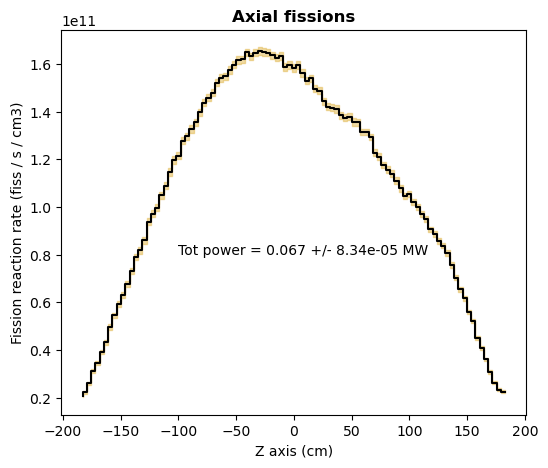

In [5]:
fig, ax = plt.subplots(figsize=(6,5))

ax.step(z_vec, RR, drawstyle = "steps-mid", color = "black")
ax.fill_between(z_vec, RR - URR, RR + URR, alpha = 0.4, step = "pre", color = "goldenrod")
ax.set_xlabel("Z axis (cm)")
ax.set_ylabel("Fission reaction rate (fiss / s / cm3)")
ax.set_title("Axial fissions", fontweight="bold")

power_calculated = np.sum(RR) * Vol * 200 * J_to_eV # MW
Upower_calculated = np.sqrt(np.sum(URR**2)) * Vol * 200 * J_to_eV # MW

ax.text(-100,0.8e11, f"Tot power = {power_calculated:.3f} +/- {Upower_calculated:.2e} MW")
fig.savefig("./pictures/axialfission.png", format = "png", dpi = 300, bbox_inches = "tight")

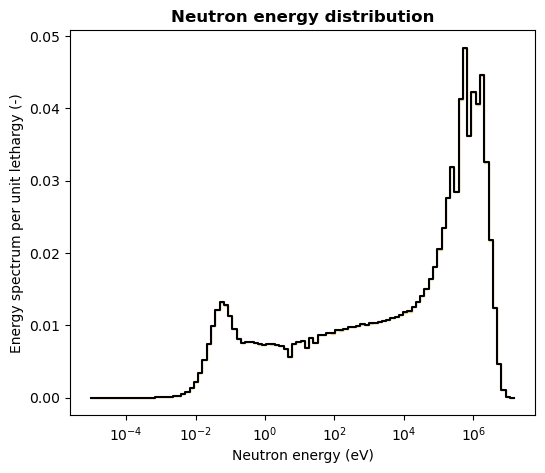

In [6]:
fig, ax = plt.subplots(figsize=(6,5))

ax.step(energies, phiE, drawstyle = "steps-mid", color = "black")
ax.fill_between(energies, phiE - UphiE, phiE + UphiE, alpha = 0.4, step = "pre", color = "goldenrod")
ax.set_xlabel("Neutron energy (eV)")
ax.set_ylabel("Energy spectrum per unit lethargy (-)")
ax.set_title("Neutron energy distribution", fontweight="bold")
ax.set_xscale("log")

fig.savefig("./pictures/energyspectrum.png", format = "png", dpi = 600, bbox_inches = "tight")